# Rose Tovar
## Advanced Linear Regression

In [13]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Upload

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRuRgiZaLcdq_937t8Psne-9AWR5VwSQYnt6PgMdDPFaVdOeP4xxA9h7_2mAYEsh8DOYzoh0XAqeQa0/pub?gid=2071196080&single=true&output=csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Initial Data Cleaning

In [4]:
# looking at object columns to see if any spelling errors
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
for col in str_cols:
  print(f"- Column = {col}")
  print(df[col].value_counts(dropna=False))
  print('\n\n')


- Column = Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



- Column = Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Column = Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Column = Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045 

In [5]:
#fixing inconsistencies in Item Fat Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', "Regular")
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Helper Methods

In [20]:
def get_train_test_split(df, y_col,drop_cols=[]):
    df = df.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    
    
    cat_selector = make_column_selector(dtype_include="object")
    cat_cols = cat_selector(X_train)
    
    num_selector = make_column_selector(dtype_include="number")
    num_cols = num_selector(X_train)
    
    freq_imputer = SimpleImputer(strategy='most_frequent')
    mean_imputer = SimpleImputer(strategy="mean")
    
    # Creating our scaler and one hot encoder

    scaler = StandardScaler()
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
        # Creating our numerical pipe 
    num_pipe = make_pipeline(mean_imputer, scaler)


    # Create the categorical pipe
    cat_pipe = make_pipeline(freq_imputer, ohe)
    
    
    # Create our tuples for the column transformer

    num_tuple = (num_pipe, num_selector)
    cat_tuple = (cat_pipe, cat_selector)
    
    preprocessor = make_column_transformer(num_tuple, cat_tuple)
    
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)
    
     ## Create the empty list
    final_features = [*num_cols,*cat_features]
    
        ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, y_train, X_test_df, y_test



In [21]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    

In [22]:
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [23]:
def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers

In [29]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df, 'Item_Outlet_Sales', ['Item_Identifier'])
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,const
4776,0.817249,-0.712775,1.828109,1.327849,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7510,0.556340,-1.291052,0.603369,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5828,-0.131512,1.813319,0.244541,0.136187,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5327,-1.169219,-1.004931,-0.952591,0.732018,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4810,1.528819,-0.965484,-0.336460,0.493686,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Initial Linear Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     291.1
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:42:40   Log-Likelihood:                -54057.
No. Observations:                6392   AIC:                         1.082e+05
Df Residuals:                    6363   BIC:                         1.084e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_Weight                        -8.1868     14.373     -0.570      0.569     -36.363      19.990
Item_Visibility                   -21.6465     14.980     -1.445      0.148     -51.012       7.719
Item_MRP                          984.5131     14.381     68.460      0.000     956.322    1012.705
Outlet_Establishment_Year        -188.6369     13.659    -13.811      0.000    -215.413    -161.861
Item_Fat_Content_Low Fat          318.0891     16.120     19.732      0.000     286.488     349.690
Item_Fat_Content_Regular          380.7143     18.005     21.145      0.000     345.419     416.009
Item_Type_Baking Goods             25.0627     53.222      0.471      0.638     -79.271     129.396
Item_Type_Breads                   -3.5856     83.479     -0.043      0.966    -167.233     160.062
Item_Type_Breakfast                70.4237    119.011      0.592      0.554    -162.878     303.725
Item_Type_Canned                   52.5789     53.011      0.992      0.321     -51.340     156.497
Item_Type_Dairy                   -81.2723     51.841     -1.568      0.117    -182.898      20.353
Item_Type_Frozen Foods             23.2920     47.338      0.492      0.623     -69.507     116.091
Item_Type_Fruits and Vegetables    70.8167     40.512      1.748      0.081      -8.601     150.235
Item_Type_Hard Drinks              38.9576     85.621      0.455      0.649    -128.889     206.804
Item_Type_Health and Hygiene       52.0881     59.034      0.882      0.378     -63.639     167.816
Item_Type_Household                30.5724     46.795      0.653      0.514     -61.162     122.307
Item_Type_Meat                     13.1978     65.458      0.202      0.840    -115.121     141.517
Item_Type_Others                   -1.7511     96.744     -0.018      0.986    -191.401     187.899
Item_Type_Seafood                 352.5638    166.346      2.119      0.034      26.470     678.657
Item_Type_Snack Foods               3.1303     40.996      0.076      0.939     -77.236      83.497
Item_Type_Soft Drinks             -14.4231     62.645     -0.230      0.818    -137.228     108.382
Item_Type_Starchy Foods            67.1515     99.092      0.678      0.498    -127.103     261.406
Outlet_Identifier_OUT010         -602.7519     28.144    -21.417      0.000    -657.924    -547.580
Outlet_Identifier_OUT013            7.8316     12.864      0.609      0.543     -17.387      33.050
Outlet_Identifier_OUT017          103.0513     33.815      3.048      0.002      36.763     169.339
Outlet_Identifier_OUT018          188.2684     17.554     10.725      0.000     153.856     222.681
Outlet_Identifier_OUT019         -323.2621     23.355    -13.841      0.000    -369.046    -277.478
Outlet_Identifier_OUT027          772.5185     15.037     51.374      0.000     743

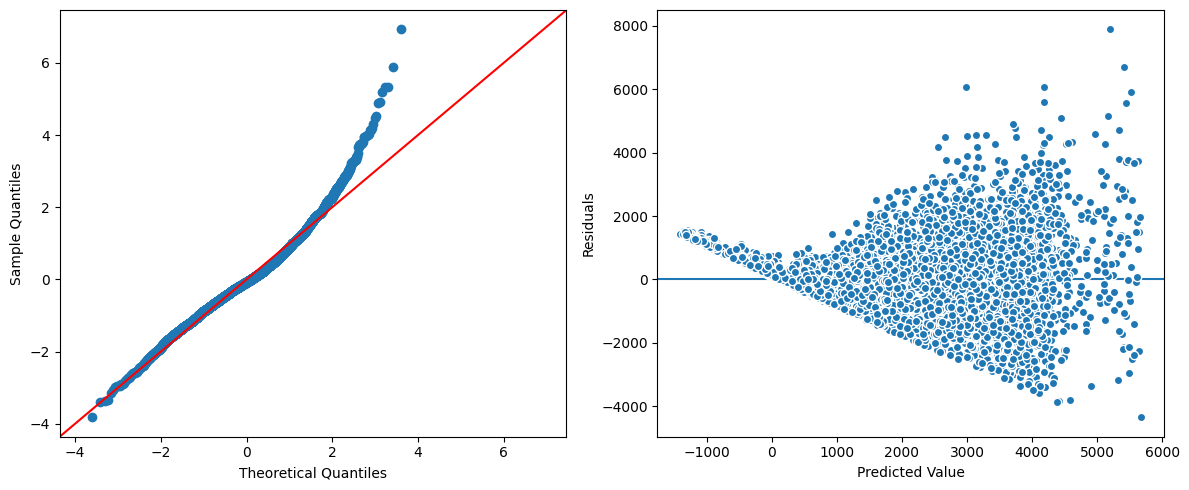

In [30]:
model = sm.OLS(y_train, X_train_df)
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

# Improving with Advanced Techniques

In [31]:
plot_df = pd.concat([X_train_df, y_train], axis=1)

In [43]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in plot_df.columns if c.startswith('Item_F') | c.startswith("Item_T") | c.startswith('Outlet_I')|c.startswith('Outlet_S')| c.startswith('Outlet_T')| c.startswith('Outlet_L')]
genre_cols
plot_cols = plot_df.drop(columns=['Item_Outlet_Sales',*genre_cols]).columns
len(plot_cols)

5

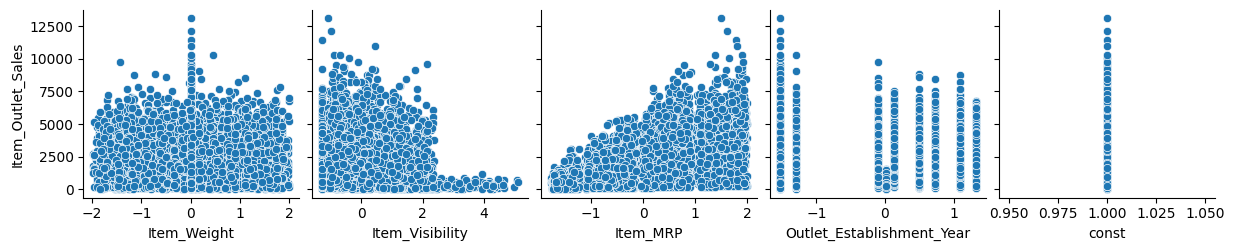

In [45]:
## Plot first 6 features
sns.pairplot(data=plot_df, y_vars='Item_Outlet_Sales',x_vars=plot_cols[:6])

- Because Item Weight and Item Visibility are not linear in any capcaity we will remove those features to see if that better helps with the model

# Model 2

In [46]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df, 'Item_Outlet_Sales', ['Item_Identifier', 'Item_Weight', "Item_Visibility"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     313.3
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:55:06   Log-Likelihood:                -54058.
No. Observations:                6392   AIC:                         1.082e+05
Df Residuals:                    6365   BIC:                         1.084e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_MRP                          984.5218     14.380     68.465      0.000     956.332    1012.711
Outlet_Establishment_Year        -187.6222     13.640    -13.755      0.000    -214.362    -160.883
Item_Fat_Content_Low Fat          318.0891     16.120     19.733      0.000     286.489     349.690
Item_Fat_Content_Regular          379.8548     17.990     21.115      0.000     344.589     415.120
Item_Type_Baking Goods             24.4224     53.212      0.459      0.646     -79.891     128.736
Item_Type_Breads                   -2.5208     83.402     -0.030      0.976    -166.017     160.975
Item_Type_Breakfast                63.4666    118.920      0.534      0.594    -169.656     296.589
Item_Type_Canned                   52.9971     53.006      1.000      0.317     -50.912     156.906
Item_Type_Dairy                   -85.8280     51.751     -1.658      0.097    -187.278      15.622
Item_Type_Frozen Foods             22.9521     47.339      0.485      0.628     -69.849     115.753
Item_Type_Fruits and Vegetables    69.6398     40.501      1.719      0.086      -9.757     149.036
Item_Type_Hard Drinks              41.8216     85.542      0.489      0.625    -125.869     209.512
Item_Type_Health and Hygiene       55.9860     58.960      0.950      0.342     -59.595     171.567
Item_Type_Household                31.1171     46.749      0.666      0.506     -60.526     122.761
Item_Type_Meat                     14.4849     65.427      0.221      0.825    -113.774     142.744
Item_Type_Others                    0.0178     96.674      0.000      1.000    -189.495     189.530
Item_Type_Seafood                 354.6215    166.343      2.132      0.033      28.533     680.710
Item_Type_Snack Foods               3.0308     40.995      0.074      0.941     -77.334      83.395
Item_Type_Soft Drinks             -11.7990     62.573     -0.189      0.850    -134.463     110.865
Item_Type_Starchy Foods            63.5341     99.048      0.641      0.521    -130.633     257.701
Outlet_Identifier_OUT010         -607.7454     27.930    -21.759      0.000    -662.498    -552.993
Outlet_Identifier_OUT013            8.4635     12.856      0.658      0.510     -16.738      33.665
Outlet_Identifier_OUT017          102.3472     33.813      3.027      0.002      36.063     168.631
Outlet_Identifier_OUT018          189.4723     17.535     10.805      0.000     155.097     223.847
Outlet_Identifier_OUT019         -327.0660     23.205    -14.095      0.000    -372.556    -281.576
Outlet_Identifier_OUT027          775.7440     14.872     52.162      0.000     746.590     804.898
Outlet_Identifier_OUT035          321.5692     25.843     12.443      0.000     270.909     372.230
Outlet_Identifier_OUT045         -150.9032     32.686     -4.617      0.000    -214

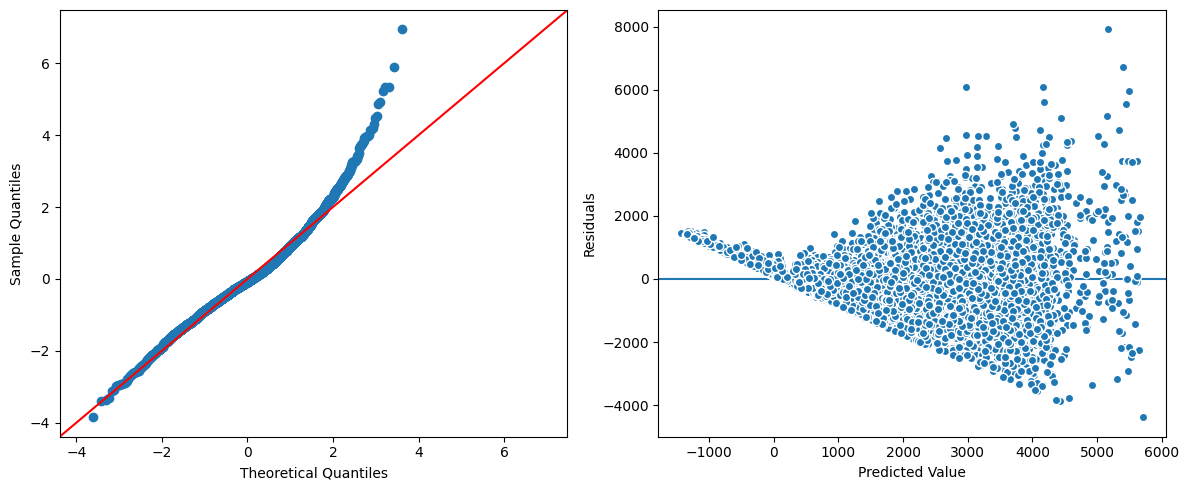

In [47]:
model = sm.OLS(y_train, X_train_df)
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

# Removing Outliers

In [48]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['Item_Outlet_Sales','Item_MRP']

outliers = {}
for col in outlier_cols:
    outliers_col = find_outliers(df[col])
    outliers[col] = outliers_col

- 90 outliers found in Item_Outlet_Sales using Z-Scores.
- 0 outliers found in Item_MRP using Z-Scores.


In [49]:
# Make new df_clean copy of df
df_clean = df.copy()

## loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean

/tmp/ipykernel_57764/1890287056.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     313.3
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:58:24   Log-Likelihood:                -54058.
No. Observations:                6392   AIC:                         1.082e+05
Df Residuals:                    6365   BIC:                         1.084e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_MRP                          984.5218     14.380     68.465      0.000     956.332    1012.711
Outlet_Establishment_Year        -187.6222     13.640    -13.755      0.000    -214.362    -160.883
Item_Fat_Content_Low Fat          318.0891     16.120     19.733      0.000     286.489     349.690
Item_Fat_Content_Regular          379.8548     17.990     21.115      0.000     344.589     415.120
Item_Type_Baking Goods             24.4224     53.212      0.459      0.646     -79.891     128.736
Item_Type_Breads                   -2.5208     83.402     -0.030      0.976    -166.017     160.975
Item_Type_Breakfast                63.4666    118.920      0.534      0.594    -169.656     296.589
Item_Type_Canned                   52.9971     53.006      1.000      0.317     -50.912     156.906
Item_Type_Dairy                   -85.8280     51.751     -1.658      0.097    -187.278      15.622
Item_Type_Frozen Foods             22.9521     47.339      0.485      0.628     -69.849     115.753
Item_Type_Fruits and Vegetables    69.6398     40.501      1.719      0.086      -9.757     149.036
Item_Type_Hard Drinks              41.8216     85.542      0.489      0.625    -125.869     209.512
Item_Type_Health and Hygiene       55.9860     58.960      0.950      0.342     -59.595     171.567
Item_Type_Household                31.1171     46.749      0.666      0.506     -60.526     122.761
Item_Type_Meat                     14.4849     65.427      0.221      0.825    -113.774     142.744
Item_Type_Others                    0.0178     96.674      0.000      1.000    -189.495     189.530
Item_Type_Seafood                 354.6215    166.343      2.132      0.033      28.533     680.710
Item_Type_Snack Foods               3.0308     40.995      0.074      0.941     -77.334      83.395
Item_Type_Soft Drinks             -11.7990     62.573     -0.189      0.850    -134.463     110.865
Item_Type_Starchy Foods            63.5341     99.048      0.641      0.521    -130.633     257.701
Outlet_Identifier_OUT010         -607.7454     27.930    -21.759      0.000    -662.498    -552.993
Outlet_Identifier_OUT013            8.4635     12.856      0.658      0.510     -16.738      33.665
Outlet_Identifier_OUT017          102.3472     33.813      3.027      0.002      36.063     168.631
Outlet_Identifier_OUT018          189.4723     17.535     10.805      0.000     155.097     223.847
Outlet_Identifier_OUT019         -327.0660     23.205    -14.095      0.000    -372.556    -281.576
Outlet_Identifier_OUT027          775.7440     14.872     52.162      0.000     746.590     804.898
Outlet_Identifier_OUT035          321.5692     25.843     12.443      0.000     270.909     372.230
Outlet_Identifier_OUT045         -150.9032     32.686     -4.617      0.000    -214

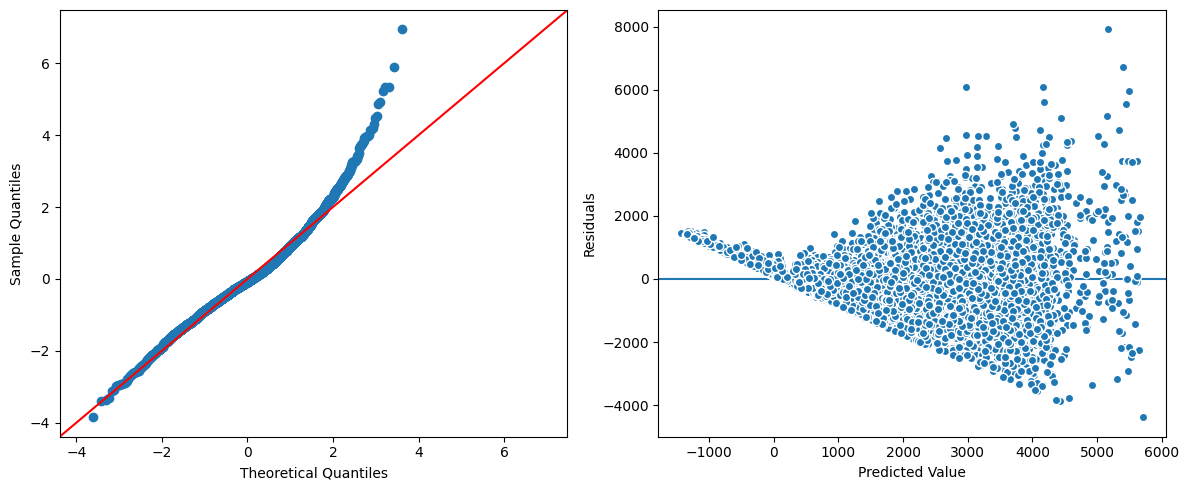

In [50]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df, 'Item_Outlet_Sales', ['Item_Identifier', 'Item_Weight', "Item_Visibility"])
model = sm.OLS(y_train, X_train_df)
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

# Removing BoxPlot Outliers

<AxesSubplot:xlabel='Item_Outlet_Sales'>

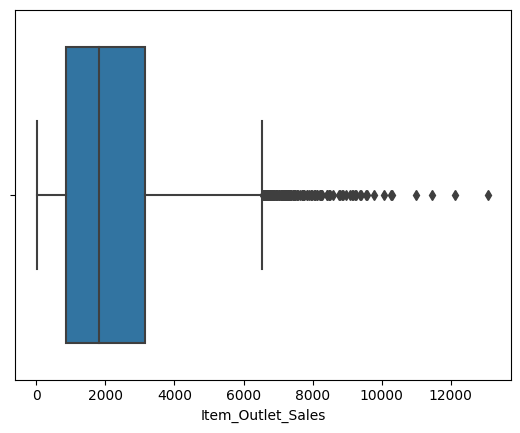

In [51]:
## visualzie outlier-removed target
sns.boxplot(x = y_train)

In [52]:
outliers_z = find_outliers(df['Item_Outlet_Sales'])
outliers_z

- 90 outliers found in Item_Outlet_Sales using Z-Scores.


0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Name: Item_Outlet_Sales, Length: 8523, dtype: bool

In [53]:
## Loop to remove outliers from same clumns using new function
outlier_cols = ['Item_Outlet_Sales','Item_MRP']

## Empty dict for both types of outliers
outliers_z = {}
outliers_iqr = {}

## Use both functions to see the comparison for # of outliers
for col in outlier_cols:
    outliers_col_z = find_outliers(df[col])
    outliers_z[col] = outliers_col_z
    
    outliers_col_iqr = find_outliers_IQR(df[col])
    outliers_iqr[col] = outliers_col_iqr

- 90 outliers found in Item_Outlet_Sales using Z-Scores.
- 186 outliers found in Item_Outlet_Sales using IQR.
- 0 outliers found in Item_MRP using Z-Scores.
- 0 outliers found in Item_MRP using IQR.


In [54]:
# remove_outliers 
df_clean_z = df.copy()
for col, idx_outliers in outliers_z.items():
    df_clean_z = df_clean_z[~idx_outliers]
df_clean_z

/tmp/ipykernel_57764/3429278998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_z = df_clean_z[~idx_outliers]


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [55]:

# remove_outliers  to create df_clean_iqr
df_clean_iqr = df.copy()
for col, idx_outliers in outliers_iqr.items():
    df_clean_iqr = df_clean_iqr[~idx_outliers]
df_clean_iqr

/tmp/ipykernel_57764/4214965391.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_iqr = df_clean_iqr[~idx_outliers]


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     306.5
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:00:43   Log-Likelihood:                -52043.
No. Observations:                6252   AIC:                         1.041e+05
Df Residuals:                    6225   BIC:                         1.043e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_MRP                          850.7573     12.765     66.649      0.000     825.734     875.780
Outlet_Establishment_Year        -131.7982     12.026    -10.960      0.000    -155.372    -108.224
Item_Fat_Content_Low Fat          299.4691     14.258     21.003      0.000     271.518     327.420
Item_Fat_Content_Regular          354.2400     15.934     22.231      0.000     323.003     385.477
Item_Type_Baking Goods             55.2261     45.564      1.212      0.226     -34.095     144.547
Item_Type_Breads                   27.7857     70.806      0.392      0.695    -111.019     166.590
Item_Type_Breakfast               -21.4266    112.154     -0.191      0.848    -241.286     198.433
Item_Type_Canned                  115.2087     46.274      2.490      0.013      24.496     205.921
Item_Type_Dairy                   -75.0180     45.874     -1.635      0.102    -164.946      14.910
Item_Type_Frozen Foods             14.8521     41.625      0.357      0.721     -66.747      96.451
Item_Type_Fruits and Vegetables    51.9224     36.689      1.415      0.157     -20.001     123.846
Item_Type_Hard Drinks              89.3610     78.923      1.132      0.258     -65.355     244.077
Item_Type_Health and Hygiene       22.6548     52.241      0.434      0.665     -79.757     125.066
Item_Type_Household                21.9559     40.877      0.537      0.591     -58.177     102.089
Item_Type_Meat                     42.3316     56.615      0.748      0.455     -68.653     153.316
Item_Type_Others                   51.1036     86.574      0.590      0.555    -118.611     220.818
Item_Type_Seafood                 209.6591    133.697      1.568      0.117     -52.434     471.752
Item_Type_Snack Foods              40.5313     36.779      1.102      0.270     -31.569     112.631
Item_Type_Soft Drinks              31.9576     53.171      0.601      0.548     -72.275     136.190
Item_Type_Starchy Foods           -24.3962     90.352     -0.270      0.787    -201.518     152.726
Outlet_Identifier_OUT010         -566.1854     24.296    -23.304      0.000    -613.814    -518.557
Outlet_Identifier_OUT013           15.3046     11.360      1.347      0.178      -6.964      37.574
Outlet_Identifier_OUT017           74.7252     29.759      2.511      0.012      16.388     133.063
Outlet_Identifier_OUT018          191.3102     15.313     12.493      0.000     161.291     221.330
Outlet_Identifier_OUT019         -313.0551     20.021    -15.636      0.000    -352.304    -273.807
Outlet_Identifier_OUT027          688.8775     13.747     50.110      0.000     661.928     715.827
Outlet_Identifier_OUT035          296.0196     23.028     12.855      0.000     250.877     341.163
Outlet_Identifier_OUT045         -131.7737     29.057     -4.535      0.000    -188

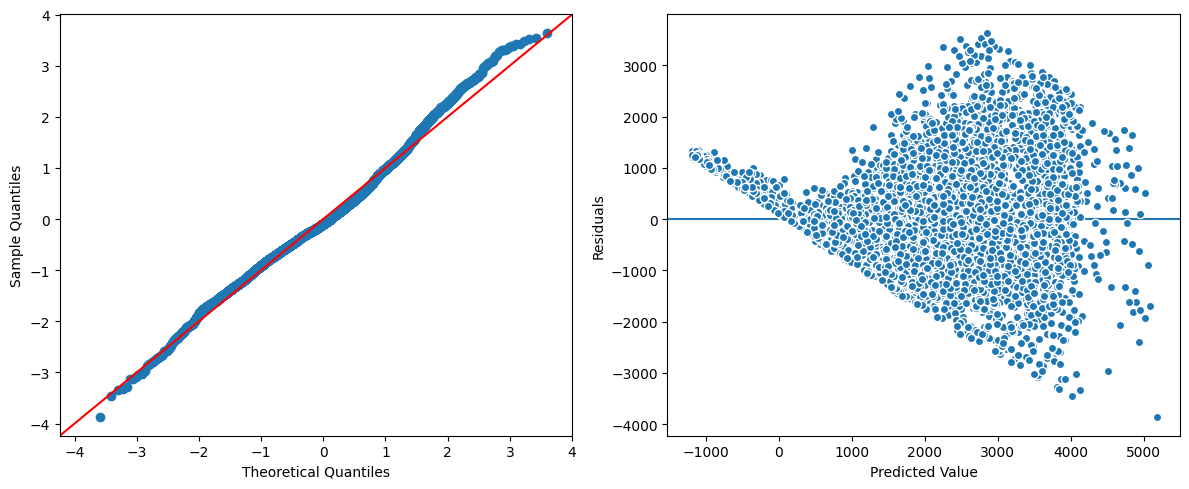

In [56]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr, 'Item_Outlet_Sales', ['Item_Identifier', 'Item_Weight', "Item_Visibility"])
model = sm.OLS(y_train, X_train_df)
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

# P Values

In [57]:
## get pvalues from model result
pvals = result.pvalues 
pvals

Item_MRP                            0.000000e+00
Outlet_Establishment_Year           1.066160e-27
Item_Fat_Content_Low Fat            1.103190e-94
Item_Fat_Content_Regular           1.982987e-105
Item_Type_Baking Goods              2.255366e-01
Item_Type_Breads                    6.947617e-01
Item_Type_Breakfast                 8.484952e-01
Item_Type_Canned                    1.281023e-02
Item_Type_Dairy                     1.020319e-01
Item_Type_Frozen Foods              7.212461e-01
Item_Type_Fruits and Vegetables     1.570594e-01
Item_Type_Hard Drinks               2.575704e-01
Item_Type_Health and Hygiene        6.645536e-01
Item_Type_Household                 5.912033e-01
Item_Type_Meat                      4.546623e-01
Item_Type_Others                    5.550182e-01
Item_Type_Seafood                   1.168939e-01
Item_Type_Snack Foods               2.704978e-01
Item_Type_Soft Drinks               5.478353e-01
Item_Type_Starchy Foods             7.871603e-01
Outlet_Identifier_OU

In [58]:
## Check for p-values that are >.05
pvals[ pvals>.05]

Item_Type_Baking Goods             0.225537
Item_Type_Breads                   0.694762
Item_Type_Breakfast                0.848495
Item_Type_Dairy                    0.102032
Item_Type_Frozen Foods             0.721246
Item_Type_Fruits and Vegetables    0.157059
Item_Type_Hard Drinks              0.257570
Item_Type_Health and Hygiene       0.664554
Item_Type_Household                0.591203
Item_Type_Meat                     0.454662
Item_Type_Others                   0.555018
Item_Type_Seafood                  0.116894
Item_Type_Snack Foods              0.270498
Item_Type_Soft Drinks              0.547835
Item_Type_Starchy Foods            0.787160
Outlet_Identifier_OUT013           0.177943
Outlet_Size_High                   0.177943
dtype: float64

In [68]:
## Get list of ALL Item Types columns to see how many are sig
item_col = [c for c in X_train_df.columns if c.startswith("Item_T")]
item_col

['Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods']

In [69]:
## save just genre pvalues
item_pvals = pvals[item_col]
## calc what % are insig?
item_pvals.sum()/len(item_pvals)

0.4379585101816865

In [70]:
outlet_cols =  [c for c in X_train_df.columns if c.startswith("Outlet_I")]
outlet_cols

['Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049']

In [71]:
outlet_pvals = pvals[outlet_cols]
outlet_pvals.sum()/len(outlet_pvals)

0.01900123219287964

In [72]:
outlet_cols =  [c for c in X_train_df.columns if c.startswith("Outlet_S")]
outlet_pvals = pvals[outlet_cols]
outlet_pvals.sum()/len(outlet_pvals)

0.05931443804173734

- Because they are less than 50% bad pvalues we will keep it

# Final Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     306.5
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:17:46   Log-Likelihood:                -52043.
No. Observations:                6252   AIC:                         1.041e+05
Df Residuals:                    6225   BIC:                         1.043e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Item_MRP                          850.7573     12.765     66.649      0.000     825.734     875.780
Outlet_Establishment_Year        -131.7982     12.026    -10.960      0.000    -155.372    -108.224
Item_Fat_Content_Low Fat          299.4691     14.258     21.003      0.000     271.518     327.420
Item_Fat_Content_Regular          354.2400     15.934     22.231      0.000     323.003     385.477
Item_Type_Baking Goods             55.2261     45.564      1.212      0.226     -34.095     144.547
Item_Type_Breads                   27.7857     70.806      0.392      0.695    -111.019     166.590
Item_Type_Breakfast               -21.4266    112.154     -0.191      0.848    -241.286     198.433
Item_Type_Canned                  115.2087     46.274      2.490      0.013      24.496     205.921
Item_Type_Dairy                   -75.0180     45.874     -1.635      0.102    -164.946      14.910
Item_Type_Frozen Foods             14.8521     41.625      0.357      0.721     -66.747      96.451
Item_Type_Fruits and Vegetables    51.9224     36.689      1.415      0.157     -20.001     123.846
Item_Type_Hard Drinks              89.3610     78.923      1.132      0.258     -65.355     244.077
Item_Type_Health and Hygiene       22.6548     52.241      0.434      0.665     -79.757     125.066
Item_Type_Household                21.9559     40.877      0.537      0.591     -58.177     102.089
Item_Type_Meat                     42.3316     56.615      0.748      0.455     -68.653     153.316
Item_Type_Others                   51.1036     86.574      0.590      0.555    -118.611     220.818
Item_Type_Seafood                 209.6591    133.697      1.568      0.117     -52.434     471.752
Item_Type_Snack Foods              40.5313     36.779      1.102      0.270     -31.569     112.631
Item_Type_Soft Drinks              31.9576     53.171      0.601      0.548     -72.275     136.190
Item_Type_Starchy Foods           -24.3962     90.352     -0.270      0.787    -201.518     152.726
Outlet_Identifier_OUT010         -566.1854     24.296    -23.304      0.000    -613.814    -518.557
Outlet_Identifier_OUT013           15.3046     11.360      1.347      0.178      -6.964      37.574
Outlet_Identifier_OUT017           74.7252     29.759      2.511      0.012      16.388     133.063
Outlet_Identifier_OUT018          191.3102     15.313     12.493      0.000     161.291     221.330
Outlet_Identifier_OUT019         -313.0551     20.021    -15.636      0.000    -352.304    -273.807
Outlet_Identifier_OUT027          688.8775     13.747     50.110      0.000     661.928     715.827
Outlet_Identifier_OUT035          296.0196     23.028     12.855      0.000     250.877     341.163
Outlet_Identifier_OUT045         -131.7737     29.057     -4.535      0.000    -188

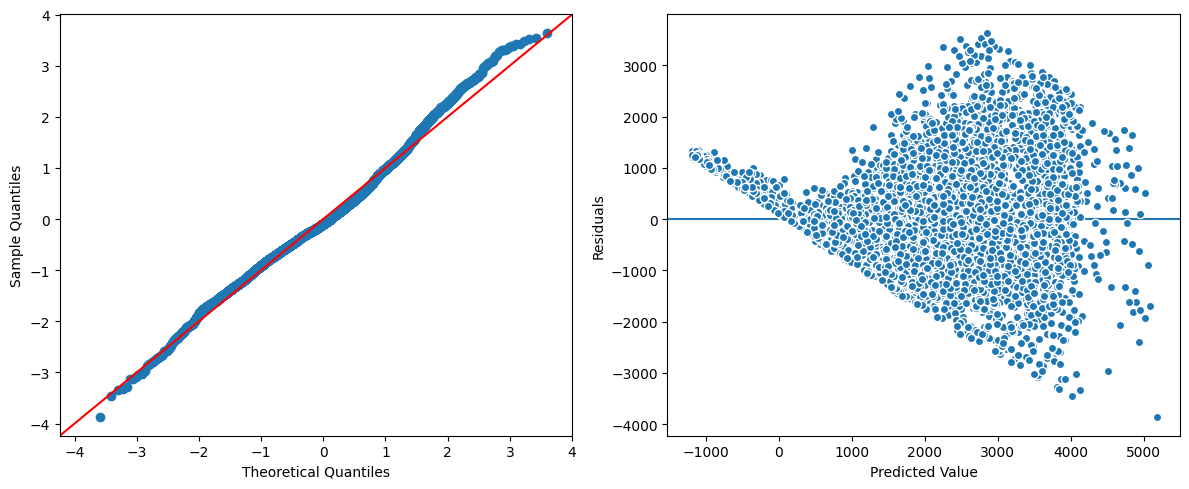

In [76]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr, 'Item_Outlet_Sales', ['Item_Identifier', 'Item_Weight', "Item_Visibility"])
model = sm.OLS(y_train, X_train_df)
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

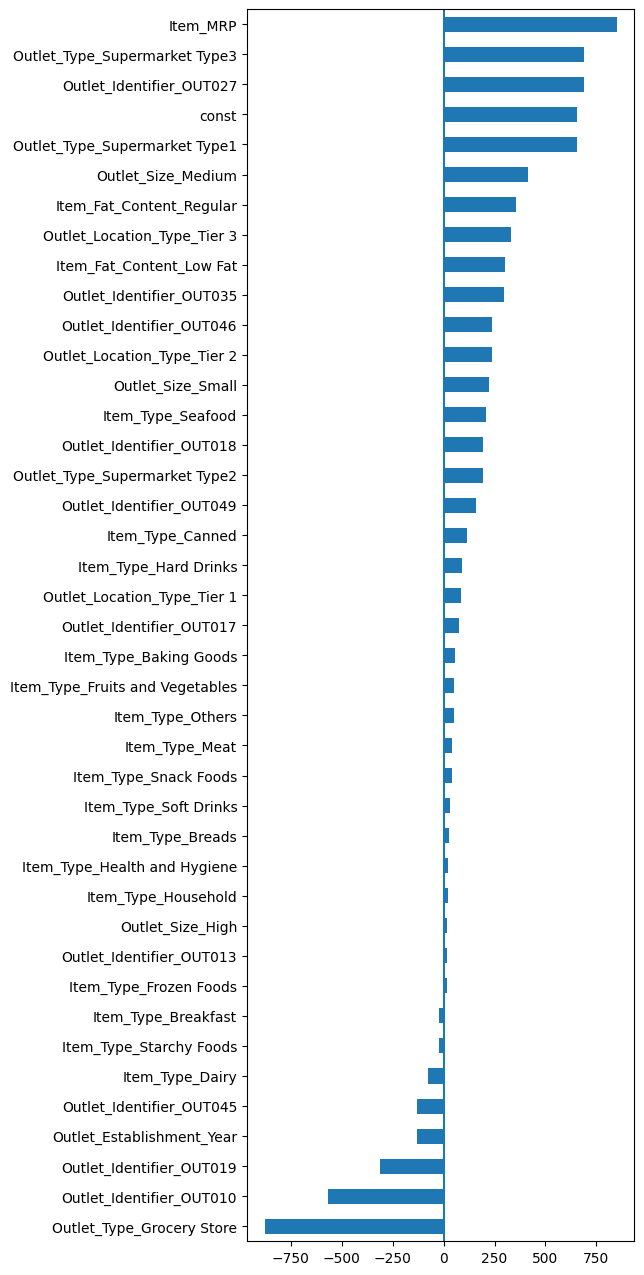

In [77]:
## Visualize Coefficients
plt.figure(figsize=(5,16))
ax =result.params.sort_values().plot(kind='barh')
ax.axvline()